In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
import texcrapy
#from konlpy.corpus import word
from ckonlpy.tag import Twitter, Postprocessor
import json
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer, LTokenizer
from soynlp.noun import LRNounExtractor_v2
from soynlp.pos.tagset import tagset
from soynlp.postagger import Dictionary as Dict
from soynlp.postagger import LRTemplateMatcher
from soynlp.postagger import LREvaluator
from soynlp.postagger import SimpleTagger
from soynlp.postagger import UnknowLRPostprocessor

import nltk
from nltk import Text
from nltk.corpus import stopwords as STOPWORDS
from nltk.corpus import words as WORDS
from nltk.tag import untag
import math
import os
import re

from threading import Thread
#from multiprocessing import Process
import dask
from dask import compute, delayed
import dask.multiprocessing
import dask.bag as db
import jpype

from gensim.models import Word2Vec, FastText
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

from wordcloud import WordCloud

sns.set(style='ticks')
rcParams['font.family'] = u'Malgun Gothic'

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Scraping

In [175]:
df = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','kw_supporter','kw_supported','keywords']]; df
_or = lambda kw: ' OR '.join(['#' + k.strip() for k in kw.split(',')])

qry_base = {row.shortname:_or(row.keywords) for row in df.itertuples()}
supporters = df.shortname[df.kw_supporter==True]
qry_sup = ' OR '.join([qry_base[sup] for sup in supporters]); qry_sup
qry = {row.shortname: '(' + qry_base[row.shortname] + ') AND (' + qry_sup + ')' if row.kw_supported==True else qry_base[row.shortname] for row in df.itertuples()}

In [ ]:
%%time
what = ['id', 'timestamp', 'text']
texcrapy.scrap(qry, what=what, lang='ko', end='2019-01-31', download_to='scrapped/twitter')

# Making Corpus

In [47]:
def preproc(text, remove_url=True, remove_mention=True, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()
    

class JsonCorpus:
    def __init__(self, *fnames, textkey='text'):
        self.fnames = fnames
        self.textkey = textkey
        self.corpus = self._corpus()

    def _corpus2(self):
        corpus = {}
        nfiles = len(self.fnames)
        _preproc = lambda doc: preproc(doc[self.textkey])
        f_preproc = np.vectorize(_preproc)
        
        for i, fname in enumerate(self.fnames):
            with open(fname, encoding='UTF-8-sig') as f: 
                for item, docs in json.load(f).items():
                    corpus[item] = f_preproc(docs) if len(docs)>0 else []
                    
                pct = '%.2f' % (100 * (i+1) / nfiles)
                print('\r {pct}% completed'.format(pct=pct), end='')
                
        print('\n')
        return corpus
    
    
    def _corpus(self):
        corpus = {}
        nfiles = len(self.fnames)
        
        for i, fname in enumerate(self.fnames):
            with open(fname, encoding='UTF-8-sig') as f:                
                for item, docs in json.load(f).items():
                    corpus[item] = [preproc(doc[self.textkey]) for doc in docs]
                
                pct = '%.2f' % (100 * (i+1) / nfiles)
                print('\r {pct}% completed'.format(pct=pct), end='')
        
        print('\n')
        return corpus
    
                
    def __iter__(self):
        for sents in self.corpus.values():
            yield from sents

    def __len__(self):
        return sum([len(sents) for sents in self.corpus.values()])
    
    def tokenize(self, tagger):
        return Tokens(tagger, **self.corpus)


class Tokens:
    def __init__(self, tagger, **corpora):
        self.tagger = tagger
        self.tokensdict = self._get_tokens2(**corpora)
    
    
    def _get_tokens(self, **corpora):
        tokens = [] #{}
        ths = []
        n_items = len(corpora)
        
        for item, corpus in list(corpora.items())[:50]:
            th = Thread(target=do_concurrent_tagging, args=(item, corpus, n_items, tokens))
            ths.append(th)
            
        for th in ths: th.start()
        for th in ths: th.join()
        
        print('\n')
        return tokens
    
    
    def _get_tokens2(self, **corpora):
        tokens = {}
        for item, corpus in tqdm_notebook(list(corpora.items())[:]):
            tokens[item] = [[w[0] for w in self.tagger.tag(corp) if w[1] is not None] for corp in set(corpus)]
        return tokens
    
    
    def freq(self):
        return {
            item: Text(sum(toks, [])).vocab() 
            for item, toks in tqdm_notebook(self.tokensdict.items())
            if item not in ['ootd','fashion','category']
        }
                
    def __iter__(self):
        for toks in self.tokensdict.values():
            yield from toks
            
    def __len__(self):
        return sum([len(toks) for toks in self.tokensdict.values()])

In [6]:
%%time
fnames = ['scrapped/twitter/' + fname for fname in os.listdir('scrapped/twitter')]
jcorpus = JsonCorpus(*fnames)

 100.00% completed

Wall time: 25.3 s


# Making Dictionary

### 1. From Scraping keywords

In [7]:
df_keywords = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')['keywords']
keywords = {w.strip() for w in ', '.join(df_keywords).split(',')}

### 2. Soynlp nouns

In [8]:
noun_extractor = LRNounExtractor_v2(verbose=True)
_soynouns = noun_extractor.train_extract(jcorpus, min_noun_score=0.3, min_noun_frequency=5)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 493329 from 429969 sents. mem=0.354 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=6680411, mem=1.464 Gb
[Noun Extractor] batch prediction was completed for 112092 words
[Noun Extractor] checked compounds. discovered 106245 compounds
[Noun Extractor] postprocessing detaching_features : 23448 -> 23277
[Noun Extractor] postprocessing ignore_features : 23277 -> 23178
[Noun Extractor] postprocessing ignore_NJ : 23178 -> 22851
[Noun Extractor] 22851 nouns (106245 compounds) with min frequency=5
[Noun Extractor] flushing was done. mem=1.701 Gb                    
[Noun Extractor] 75.02 % eojeols are covered


In [14]:
soynouns = _soynouns.keys()
soyngrams = {v for k,v in noun_extractor._compounds_components.items() if k in soynouns}

In [162]:
word_extractor = WordExtractor?

In [177]:
word_extractor = WordExtractor()
word_extractor.train(jcorpus)
_soywords = word_extractor.extract()

training was done. used memory 3.677 Gbse memory 3.832 Gb
all cohesion probabilities was computed. # words = 264323
all branching entropies was computed # words = 446112
all accessor variety was computed # words = 446112


In [178]:
def word_score(score):
    return score.cohesion_forward * math.exp(score.right_branching_entropy)

soywords = {word for word, score in soywords.items() if word_score(score)>0.1}

### 3. Korean words

In [180]:
with open('dic_system.txt', encoding='UTF-8-sig') as f:
    lines = f.readlines()
    
kowords = {tok.split('\t')[0] for tok in lines}

### 4. English words

In [181]:
enwords = set(WORDS.words())

### 5. Custom words

In [182]:
cwords = '''
'''

cwords = set(re.findall(r'[^ ,]+', re.sub(r'\n', '', cwords)))

In [183]:
pos_dict = {
    'Adverb': {}, 
    'Noun': keywords | soynouns | soywords | kowords | enwords | cwords, 
    'Josa': {},
    'Verb': {},
    'Adjective': {},
    'Exclamation': {},
}

dictionary = Dict(pos_dict)
generator = LRTemplateMatcher(dictionary)    
evaluator = LREvaluator()
postprocessor = UnknowLRPostprocessor()
tagger = SimpleTagger(generator, evaluator, postprocessor)

In [184]:
tagger.tag(jcorpus.corpus['crocs'][250])

[('가성비', 'Noun'),
 ('좋', None),
 ('기로', 'Noun'),
 ('소문', 'Noun'),
 ('난', None),
 ('크록스', 'Noun'),
 ('중에서도', 'Noun'),
 ('레이웨지', 'Noun'),
 ('키작녀', 'Noun'),
 ('에게', 'Noun'),
 ('최고', 'Noun'),
 ('지', None),
 ('여름', 'Noun'),
 ('엔', None),
 ('정', None),
 ('했다', 'Noun'),
 ('ak몰', 'Noun'),
 ('패션', 'Noun'),
 ('신발', 'Noun'),
 ('패션잡화', 'Noun'),
 ('웨지힐', 'Noun')]

In [185]:
%%time
tokens = jcorpus.tokenize(tagger)


Wall time: 3min 17s


In [42]:
set(jcorpus.corpus['crocs']);

In [187]:
tokens.tokensdict['crocs'];

# Tagger setup

### 1. Passtags

In [43]:
stoptags = {'Foreign','Punctuation','KoreanParticle','Josa','Eomi','PreEomi','Exclamation','Determiner'}
passtags = set(twitter.tagset.keys()) - stoptags

### 2. Stopwords

In [70]:
stopwords_en = STOPWORDS.words('english')

with open('stopwords-ko.json', encoding='UTF-8-sig') as f:
    stopwords_ko = json.load(f)
    
stopwords_custom = '''
    엔, 줄, 내, 에는, 잖아요, 라는, 데, 는, 것은, 는, 인가요, 란, 말인가, 시, 은, 하네, 이나, 지, 있음, 수, 있는, 
    있으신가, 요, 그렇다면, 하고, 내는, 후, 생, 가거, 한, 하시겠어요, 만, 되네, 하려면, 하다, 랑, 하게, 근데, pic, 님의, 
    호, 하세요, 흑, 적인, 다욧, 니, 보니, 건, 다, 위해, 히, 께, 난, 해, 면서, 용, 보자, 가서, 하는, 중, 도, 
    잉, 인, 울, 하러가기, 인, 준, 든, 이셨으면, 와의, 
    드는, 되네요, 크흐, 이걸, 서, 에도, 됩니다, 하다고, 날, 
    하네요, 했습니다, 해지네요, 이였냐, 더, 
    되니, 하지않을, 아아, htm, 고, 냐고, 이야, 아니야, 너네, 된, 이냐, 해봐라, 해서, 
    vi, 
'''    

stopwords_custom = re.findall(r'[^ ,]+', re.sub(r'\n','',stopwords_custom))
stopwords = set(stopwords_en + stopwords_ko)# + stopwords_custom)

### 3. N-grams

In [45]:
cngrams = {
    ('캘빈','클라인'),('켈빈','클라인'),
}
#     ('the','boyz'),
#     ('어글리','슈즈'),
#     ('리미티드','에디션'),
#     ('키코','코스타디노브'), ('kiko','kostadinov'),
#     ('젤','카야노'),
#     ('젤','라이트'),('gel','lyte'),
#     ('스튜어트','와이츠먼'),
#     ('주니','블랙'),
#     ('jun','hyo','seong'),
#     ('gel','ptg'),
#     ('오니츠카','타이거'),
#     ('노박','조코비치'),
#     ('후디','티셔츠'),
#     ('최종병기','활'),
#     ('아이제아','토마스'),
#     ('gel','ace')
# ]

ngrams = list(cngrams | soyngrams)

In [56]:
tagger = Postprocessor(twitter)#, stopwords=stopwords, passtags=passtags, ngrams=ngrams)

In [32]:
%%time
tokens = jcorpus.tokenize(tagger)


Wall time: 1h 16min 13s


In [62]:
def do_concurrent(tagger, item, corpus):
    return item, [untag(tagger.tag(corp)) for corp in corpus]

In [52]:
%%time
if __name__ == '__main__':
    values = [delayed(do_concurrent)(tagger, item, corpus) for item, corpus in list(jcorpus.corpus.items())[:5]]
    result = compute(*values, scheduler='processes')

Wall time: 29.6 s


In [63]:
%%time
test = [do_concurrent(tagger, item, corpus) for item, corpus in list(jcorpus.corpus.items())[:5]]

Wall time: 3.13 s


In [188]:
tokensfreq = tokens.freq()

In [189]:
with open('model/tokensfreq.json', 'w', encoding='UTF-8-sig') as f:
    json.dump(tokensfreq, f, ensure_ascii=False)

In [3]:
with open('model/tokensfreq.json', encoding='UTF-8-sig') as f:
    tokensfreq = json.load(f)

In [33]:
tokensfreq.keys();

# Word2vec

In [190]:
w2v = Word2Vec(tokens, size=100, window=5, min_count=10, workers=4, sg=1)
w2v.save('model/word2vec.model')

In [191]:
w2v.init_sims(replace=True)

In [2]:
%%time
w2v = Word2Vec.load('model/word2vec.model')

Wall time: 1.13 s


In [29]:
blist = pd.read_excel('keywords and logos.xlsx', sheet_name='20190304')[['shortname','keywords']][3:].to_dict('record')

In [30]:
res = []
for brand1 in blist:
    for brand2 in blist:
        b1 = [w.strip() for w in brand1['keywords'].split(',')]
        b2 = [w.strip() for w in brand2['keywords'].split(',')]
        
        try:
            sim = w2v.wv.n_similarity(b1, b2)
            res.append((brand1['shortname']+'-'+brand2['shortname'], sim))
            
        except:
            _b1 = [w for w in b1 if w in w2v.wv.vocab]
            _b2 = [w for w in b2 if w in w2v.wv.vocab]
            if len(_b1)*len(_b2)!=0:
                sim = w2v.wv.n_similarity(_b1, _b2)
                res.append((brand1['shortname']+'-'+brand2['shortname'], sim))

In [31]:
sorted(res, key=lambda x:x[1])

[('tods-newera', -0.12983424886868136),
 ('newera-tods', -0.12983424886868136),
 ('patagonia-valentino', -0.10357279775721215),
 ('valentino-patagonia', -0.10357279775721215),
 ('kuho-yeezy', -0.10329808901096638),
 ('yeezy-kuho', -0.10329808901096638),
 ('soup-abecrombiefitch', -0.0956901706675369),
 ('abecrombiefitch-soup', -0.0956901706675369),
 ('beanpole-y3', -0.0936294050932798),
 ('y3-beanpole', -0.0936294050932798),
 ('patagonia-billylosangeles', -0.09244410385853158),
 ('billylosangeles-patagonia', -0.09244410385853158),
 ('valentino-helinox', -0.08826646256095232),
 ('helinox-valentino', -0.08826646256095232),
 ('oakley-billylosangeles', -0.08517653840085804),
 ('billylosangeles-oakley', -0.08517653840085804),
 ('coach-billylosangeles', -0.08096358456108801),
 ('billylosangeles-coach', -0.08096358456108801),
 ('buckaroo-rimowa', -0.0752983168677062),
 ('rimowa-buckaroo', -0.0752983168677062),
 ('adidas-billylosangeles', -0.07392189180870536),
 ('billylosangeles-adidas', -0.07

In [86]:
%%time
dd = dict(w2v.wv.most_similar(positive=['사랑','가성비','스포티'], topn=1000))

Wall time: 33 ms


In [105]:
%%time
out = {}
for bname in tokensfreq.keys():
    try:
        out[bname] = w2v.wv.n_similarity([bname], ['편한','여성스러운'])
    except:
        pass

out = sorted(out.items(), key=lambda x: x[1])

Wall time: 75 ms


In [106]:
out

[('mastermind', -0.006401319),
 ('peaceminusone', 0.027468547),
 ('bbc', 0.040993202),
 ('ambush', 0.057285804),
 ('champion', 0.05957389),
 ('newera', 0.06278716),
 ('spyder', 0.074900046),
 ('supreme', 0.07546665),
 ('haveagoodtime', 0.08361644),
 ('stussy', 0.08451557),
 ('wilson', 0.090866975),
 ('bape', 0.09162498),
 ('puma', 0.0918758),
 ('c2h4', 0.100677654),
 ('rimowa', 0.101043925),
 ('openingceremony', 0.103725255),
 ('032c', 0.11065915),
 ('canadagoose', 0.11088306),
 ('gucci', 0.11295648),
 ('richardson', 0.11307342),
 ('hermes', 0.11356528),
 ('incase', 0.118717924),
 ('oakley', 0.119101115),
 ('aape', 0.1215327),
 ('givenchy', 0.12167882),
 ('umbro', 0.121925),
 ('humanmade', 0.12245312),
 ('ovo', 0.12417588),
 ('rickowens', 0.12646002),
 ('thisisneverthat', 0.12673298),
 ('palace', 0.12957528),
 ('louisvuitton', 0.13230659),
 ('reebok', 0.1342256),
 ('antisocialsocialclub', 0.13575545),
 ('porter', 0.13607305),
 ('versace', 0.13831924),
 ('brixton', 0.13854636),
 ('gosha

In [215]:
id_pools = {
    '럭셔리': '럭셔리,고급,호화,luxury', 
    '캐주얼': '캐주얼,캐쥬얼,casual', 
    
    '유니크': '유니크,독특,독창,unique,개성,only,참신,신선,특이,아이디어',
    '대중성': '대중,popular,mass,흔한', 
    
    '정통성': '정통,traditional,클래식,classic,품격', 
    '트렌디': '트렌디,트랜디,트렌드,트랜드,유행,trend,trendy,변화,변동,새로운',#,'민감'],
    
    '포멀': '포멀,노멀,normal,평범,일상',
    '화제성': '화제,인기,hot,튀는', 
    
    #'가성비': ['가성비','저렴','효율','성능','실용'], 
    #'신뢰성': ['신뢰','믿음','trust','견고','품질','안정','클래식','classic'],
    #'활동성': ['활동','활발','운동','액티브','스포츠','active','sport','sports','sporty'],
    #'과감함': ['과감','선도','선구','대담','강렬','선명','예술','art'],
    # 철학, 환상, 신상, 새로운, 
}

In [216]:
dct = Dictionary(tokens)
dct.filter_extremes(no_below=20, no_above=0.2)
dct.compactify()

In [217]:
corp = {item:[dct.doc2bow(tok) for tok in toks] for item, toks in tqdm_notebook(tokens.tokensdict.items())}

In [218]:
model_tfidf = TfidfModel(sum(corp.values(),[]), id2word=dct)

In [219]:
wordlist = list(dct.values())
identities = list(id_pools.keys())
brands = list(tokens.tokensdict.keys())

In [220]:
sim_mat = np.zeros((len(identities),len(wordlist)))
for i, idty in enumerate(tqdm_notebook(identities)):
    for j, word in enumerate(wordlist):
        sims = []
        for w in id_pools[idty].split(','):
            try:
                sims.append(w2v.wv.similarity(w, word))
            except:
                pass
                #sims.append(0)
        sim_mat[i,j] = np.mean(sims)
        #sim_mat[i,j] = np.mean([w2v.wv.similarity(w, word) for w in id_pools[idty]])

In [221]:
sim_mat.shape

(8, 25749)

In [222]:
def get_brand_vecs(bname):
    brand_tfidf  = model_tfidf[corp[bname]]
    return np.vstack([sparse2full(c, len(dct)) for c in brand_tfidf]).mean(axis=0)

def plot_id(bname):
    val = sim_mat.dot(get_brand_vecs(bname))
    #val /= val.sum()
    pd.Series(val, index=identities).plot.barh()

In [223]:
id_dict = {}
for bname in brands:
    if bname not in ['ootd','fashion','category']:
        try:
            id_dict[bname] = sim_mat.dot(get_brand_vecs(bname))
        except:
            print(bname)

advisoryboardcrystals
doublet
engineeredgarment
experthorror
goat
heliotemil
ignoredprayers
novacancyinn
onlineceramics
saterdaysnyc
someware
sssworldcorp
ystrdystmrrw


In [224]:
pd.DataFrame(id_dict, index=identities).to_pickle('model/id_dict.pkl')

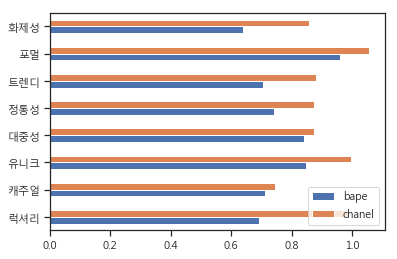

In [252]:
df = pd.DataFrame(id_dict, index=identities) #pd.read_pickle('model/id_dict.pkl')
#df /= df.sum()
df[['bape','chanel']].plot.barh()

In [226]:
df_id = pd.DataFrame(columns=df.columns)
df_id.loc['럭셔리-캐주얼'] = df.loc['럭셔리'] / (df.loc['럭셔리'] + df.loc['캐주얼'])
df_id.loc['유니크-대중성'] = df.loc['유니크'] / (df.loc['유니크'] + df.loc['대중성'])
df_id.loc['정통성-트렌디'] = df.loc['정통성'] / (df.loc['정통성'] + df.loc['트렌디'])
df_id.loc['포멀-화제성'] = df.loc['포멀'] / (df.loc['포멀'] + df.loc['화제성'])

In [253]:
df_id.to_pickle('model/id_dict.pkl')

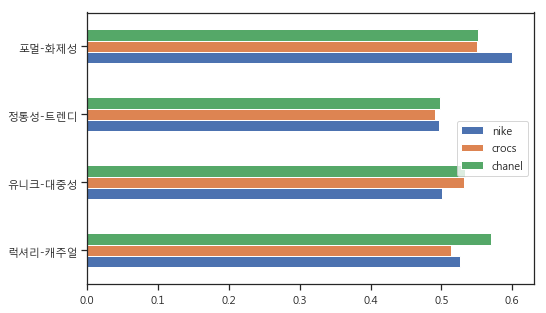

In [235]:
df_id[['nike','crocs','chanel']].plot.barh(figsize=(8,5))

# 여기서 normalize 축을 바꾸면 어떨까?

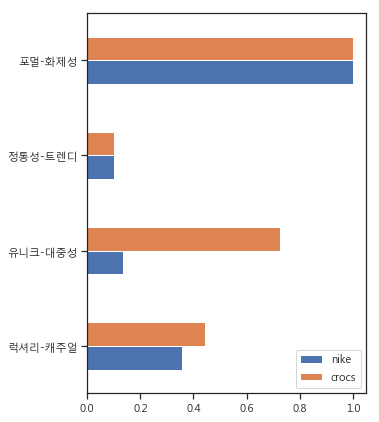

In [243]:
#df = pd.read_pickle('model/id_dict.pkl')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(df_id)
df2 = df_id.copy()
df2[:] = X_train_minmax
df2[['nike','crocs']].plot.barh(figsize=(5,7))

In [245]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(df2.T)
# cluster = KMeans(n_clusters=10, random_state=0).fit(X_reduced)
# cluster = DBSCAN().fit(X_reduced)
cluster = AffinityPropagation().fit(X_reduced)
clustered = pd.Series(cluster.labels_, index=df2.columns); clustered

032c                    12
1017alyx9sm             12
8seconds                 2
99percentis              1
aape                    14
abecrombiefitch         11
acnestudios              9
acoldwall               13
acronym                 12
adererror                6
adidas                  12
adidasoriginal           0
aecawhite                6
aimeleondore            18
aldo                     6
alexandermcqueen        10
alexanderwang            0
allsaints                7
alphaindustry            7
ambush                   1
ami                      7
amiri                    2
antisocialsocialclub     1
apc                      6
arcteryx                15
asics                   18
awakeny                 10
balenciaga               0
bally                    3
balmain                 10
                        ..
tomsshoes                6
topshop                 18
topten                   2
toryburch               17
tumi                    10
ugg                      0
u

In [247]:
clrd = pd.DataFrame(clustered.sort_values()).reset_index()
clrd.columns = ['bname', 'cluster']
clrd.to_excel('model/clustered.xlsx')

In [250]:
clrd[clrd.bname=='chanel']

,bname,cluster
158,chanel,10


In [251]:
clustered.index[clustered==10]

Index(['alexandermcqueen', 'awakeny', 'balmain', 'bottegaveneta', 'burberry',
       'chanel', 'dior', 'dkny', 'ermenegildozegna', 'fendi', 'ferragamo',
       'gentlemonster', 'gucci', 'hermes', 'heronpreston', 'lanvin',
       'louisvuitton', 'n21', 'prada', 'tods', 'tumi', 'versace'],
      dtype='object')

In [323]:
df2.loc['신뢰성']

032c                    0.921131
1017alyx9sm             1.000000
8seconds                0.894010
99percentis             0.773222
aape                    0.975499
abecrombiefitch         0.844910
acnestudios             1.000000
acoldwall               1.000000
acronym                 1.000000
adererror               1.000000
adidas                  0.907210
adidasoriginal          1.000000
aecawhite               1.000000
aimeleondore            0.809190
aldo                    1.000000
alexandermcqueen        1.000000
alexanderwang           1.000000
allsaints               1.000000
alphaindustry           0.916350
ambush                  0.815106
ami                     0.947703
amiri                   0.979774
antisocialsocialclub    0.971174
apc                     0.955957
arcteryx                0.983103
asics                   0.862977
awakeny                 0.987181
balenciaga              1.000000
bally                   0.899009
balmain                 0.930140
          

In [325]:
df_kw = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','keywords']].set_index('shortname')
df_kw;

In [326]:
def plot_wc(bname):
    with open('model/tokensfreq.json', encoding='UTF-8-sig') as f:
        j = json.load(f)[bname]
        kws = [kw.strip() for kw in df_kw.keywords.loc[bname].split(',')]
        [j.pop(kw, None) for kw in kws]

    x,y = np.ogrid[:300, :300]
    mask = (x-150)**2 + (y-150)**2 > 130**2
    mask = 255 * mask.astype(int)
        
    font_path = r'c:\Windows\Fonts\NanumBarunGothic.ttf'
    wc = WordCloud(width=100, height=100, background_color='white', font_path=font_path, random_state=0, mask=mask)
    
    try:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(wc.generate_from_frequencies(j), interpolation='bilinear')
        ax.axis('off')
        fig.savefig('model/wordcloud/wc_' + bname + '.png', format='png')
        
    except:
        print(bname)
        
    finally:
        plt.close(fig)

In [327]:
for row in tqdm_notebook(df_kw.itertuples()):
    bname = row.Index
    
    fname = 'model/wordcloud/wc_' + bname + '.png'
    if os.path.isfile(fname):
        continue
        
    if bname not in ['ootd','fashion','category']:
        plot_wc(bname)

doublet
engineeredgarment
ignoredprayers
saterdaysnyc
advisoryboardcrystals
experthorror
goat
heliotemil
novacancyinn
onlineceramics
someware
sssworldcorp
ystrdystmrrw


In [9]:
df2.T['신뢰성'].sort_values()

soup               0.478494
thursdayisland     0.523196
hconnect           0.535815
discovery          0.558666
maxmara            0.597487
fog                0.599294
munsingwear        0.600664
coteciel           0.614565
mine               0.630577
k2                 0.631754
topten             0.649428
bbc                0.657800
buckaroo           0.695261
reigningchamp      0.700859
coach              0.706395
gap                0.710637
mains              0.710886
plac               0.716768
maje               0.718295
placesplusfaces    0.724394
umbro              0.729065
mlb                0.732206
plasticisland      0.739186
topshop            0.745188
charms             0.745581
nonnative          0.750487
lecoqsportif       0.752308
tomboy             0.753768
hoodbyair          0.754262
palace             0.763309
                     ...   
porter             1.000000
everywear          1.000000
montblanc          1.000000
liful              1.000000
carhartt           1